In [ ]:
!git clone https://github.com/charlesdong1991/interpretable-han-for-document-classification-with-keras.git

Cloning into 'interpretable-han-for-document-classification-with-keras'...
remote: Enumerating objects: 141, done.
remote: Total 141 (delta 0), reused 0 (delta 0), pack-reused 141
Receiving objects: 100% (141/141), 119.87 KiB | 3.33 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
!git clone https://github.com/jiesutd/Text-Attention-Heatmap-Visualization.git

Cloning into 'Text-Attention-Heatmap-Visualization'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/interpretable-han-for-document-classification-with-keras

/content/interpretable-han-for-document-classification-with-keras


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating hierachical_attention_network_for_document_classification.egg-info
writing hierachical_attention_network_for_document_classification.egg-info/PKG-INFO
writing dependency_links to hierachical_attention_network_for_document_classification.egg-info/dependency_links.txt
writing requirements to hierachical_attention_network_for_document_classification.egg-info/requires.txt
writing top-level names to hierachical_attention_network_for_document_classification.egg-info/top_level.txt
writing manifest file 'hierachical_attention_network_for_document_classification.egg-info/SOURCES.txt'
writing manifest file 'hierachical_attention_network_for_document_classification.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/han
copying han/__init__.py -> build/lib/han
copying han/model.py -> build/lib/han
copying han/utils.py -> bu

In [ ]:
import sys
sys.path.insert(0,'content/interpretable-han-for-document-classification-with-keras')
#from han.model import HAN



In [ ]:
"""
This example applies the HAN classifier to Kaggle's IMDB
review dataset. The goal is to predict whether a review is
positive (5 star rating >=3) or negative (otherwise)
"""

import re
import numpy as np
import pandas as pd
import logging
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from han.model import HAN
import nltk
nltk.download('punkt')

# Create a logger to provide info on the state of the
# script
stdout = logging.StreamHandler(sys.stdout)
stdout.setFormatter(logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
))
logger = logging.getLogger('default')
logger.setLevel(logging.INFO)
logger.addHandler(stdout)


#max_doc_length = 30
#max_doc_num = 5
max_sent_length = 100
max_sent_num = 25
MAX_VOC_SIZE = 20000
GLOVE_DIM = 200
TEST_SPLIT = 0.1


#####################################################
# Pre processing                                    #
#####################################################
logger.info("Pre-processsing data.")

# Load Kaggle's IMDB example data
#data = pd.read_csv('/Users/maryam/Desktop/keras-han-for-docla/labeledTrainData.tsv', sep='\t')
#data = pd.read_csv('/content/labeledTrainData.tsv', sep='\t')
data = pd.read_csv('/content/Total.csv', encoding='latin1')


"""
# Do some basic cleaning of the review text
def remove_quotations(text):
    
    #Remove quotations and slashes from the dataset.
    
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)
    return text


def remove_html(text):
    
    #Very, very raw parser to remove HTML tags from
    #texts.
   
    tags_regex = re.compile(r'<.*?>')
    return tags_regex.sub('', text)


data['review'] = data['review'].apply(remove_quotations)
data['review'] = data['review'].apply(remove_html)
data['review'] = data['review'].apply(lambda x: x.strip().lower())
"""
# Get the data and the sentiment
reviews = data['review'].values
#reviews = data.iloc[:,1:6].values
target = data['sentiment'].values
#del data


#####################################################
# Tokenization                                      #
#####################################################
logger.info("Tokenization.")

# Build a Keras Tokenizer that can encode every token
word_tokenizer = Tokenizer(num_words=MAX_VOC_SIZE)
word_tokenizer.fit_on_texts(reviews)

# Construct the input matrix. This should be a nd-array of
# shape (n_samples, max_sent_num, max_sent_length).
# We zero-pad this matrix (this does not influence
# any predictions due to the attention mechanism.


X = np.zeros((len(reviews), max_sent_num, max_sent_length), dtype='int32')
#X = np.zeros((len(data), max_doc_num , max_sent_num, max_sent_length), dtype='int32')



for i, review in enumerate(reviews):
    sentences = sent_tokenize(review)
    tokenized_sentences = word_tokenizer.texts_to_sequences(
        sentences
    )
    tokenized_sentences = pad_sequences(
        tokenized_sentences, maxlen=max_sent_length
    )

    pad_size = max_sent_num - tokenized_sentences.shape[0]

    if pad_size < 0:
        tokenized_sentences = tokenized_sentences[0:max_sent_num]
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0,pad_size),(0,0)),
            mode='constant', constant_values=0
        )

    # Store this observation as the i-th observation in
    # the data matrix
    X[i] = tokenized_sentences[None, ...]

# Transform the labels into a format Keras can handle
y = to_categorical(target)

# We make a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT)


#####################################################
# Word Embeddings                                   #
#####################################################
logger.info(
    "Creating embedding matrix using pre-trained GloVe vectors."
)

# Now, we need to build the embedding matrix. For this we use
# a pretrained (on the wikipedia corpus) 100-dimensional GloVe
# model.

# Load the embeddings from a file
embeddings = {}
with open('/content/drive/My Drive/glove/glove.6B.%dd.txt' % GLOVE_DIM, encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')

        embeddings[word] = coefs

# Initialize a matrix to hold the word embeddings
embedding_matrix = np.random.random(
    (len(word_tokenizer.word_index) + 1, GLOVE_DIM)
)

# Let the padded indices map to zero-vectors. This will
# prevent the padding from influencing the results
embedding_matrix[0] = 0

# Loop though all the words in the word_index and where possible
# replace the random initalization with the GloVe vector.
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2020-08-04 14:36:48,645 - default - INFO - Pre-processsing data.
2020-08-04 14:36:48,669 - default - INFO - Tokenization.
2020-08-04 14:36:48,858 - default - INFO - Creating embedding matrix using pre-trained GloVe vectors.


In [ ]:
tokenized_sentences = word_tokenizer.texts_to_sequences(
        sentences
    )

In [ ]:
tokenized_sentences1 = pad_sequences(
        tokenized_sentences, maxlen=max_sent_length
    )

In [ ]:
tokenized_sentences[0]

[1, 189, 3, 1, 40, 1, 33, 3, 83, 6, 61, 1, 20]

In [ ]:
tokenized_sentences1[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 189,   3,   1,
        40,   1,  33,   3,  83,   6,  61,   1,  20], dtype=int32)

In [ ]:
X[1].shape

(25, 100)

In [ ]:
word_index = word_tokenizer.word_index

In [ ]:
from han.attention import Attention

Using TensorFlow backend.


In [ ]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Embedding, Dense, GRU, Bidirectional, TimeDistributed, Lambda
from keras.callbacks import ModelCheckpoint

from han.attention import Attention

DENSE_SIZE = 100


class HAN(Model):
    def __init__(self, embedding_matrix, max_doc_length=30, max_sent_length=100,
                 max_sent_num=10, max_doc_num=5, word_embed_dim=100, sent_embed_dim=100, doc_embed_dim=300):
        """Implementation of Hierarchical Attention Networks for document classification.

        Args:
            embedding_matrix: embedding matrix used to represent words.
            max_sent_length: int, maximum number of words per sentence, default is 100.
            max_sent_num: int, maximum number of sentences accepted, default is 10.
            word_embed_dim: int, dimension of word encoder, default is 100.
            sent_embed_dim: int, dimension of sentence encoder, default is 100.
        
            ************************************
            max_doc_length: int, maximum number of sentences per document, default is 30. ???????
            max_doc_num: int, maximum number of documents per patient, default is 5.
            doc_embed_dim: int, dimension of document encoder, default is 300.  
            
        """
        self.embedding_matrix = embedding_matrix
        self.max_sent_length = max_sent_length
        self.max_sent_num = max_sent_num
        self.word_embed_dim = word_embed_dim
        self.sent_embed_dim = sent_embed_dim
        
        self.max_doc_length= max_doc_length
        self.max_doc_num=max_doc_num
        self.doc_embed_dim=doc_embed_dim

        super(HAN, self).__init__(name='han')
        #self.build_model()

    def build_word_encoder(self):
        """Build word encoder.

        The function starts with a Input tensor layer, and go through
        Embedding layer and then Bidirectional GRU layer and
        TimeDistributed layer and ends with Attention.

        Returns:
            Model, a model layer wraps sent_input and word attention.
        """
        sent_input = Input(shape=(self.max_sent_length,), dtype='float32')
        embedded_sent = Embedding(
            self.embedding_matrix.shape[0], self.embedding_matrix.shape[1],
            weights=[self.embedding_matrix], input_length=self.max_sent_length,
            trainable=False
        )(sent_input)

        # For Bidirectional, devide by 2
        encoded_sent = Bidirectional(
            GRU(int(self.word_embed_dim / 2), return_sequences=True)
        )(embedded_sent)
        # TODO: check if dense is still needed in timedistributed
        dense_sent = TimeDistributed(Dense(DENSE_SIZE))(encoded_sent)

        word_att = Attention(name='word_attention')(dense_sent)

        return Model(sent_input, word_att)

In [ ]:
model = HAN(embedding_matrix, max_sent_length=100, max_sent_num=25, max_doc_num=5, word_embed_dim=100, sent_embed_dim=100, doc_embed_dim=300)


W0820 20:15:09.860084 139865516341120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 20:15:09.906810 139865516341120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 20:15:09.914981 139865516341120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 20:15:09.926078 139865516341120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0820 20:15:09.927987 1398655163

In [ ]:
embedding_matrix.shape[0]

1373

In [ ]:
word_embed_dim=100
sent_embed_dim=100

In [ ]:
sent_input = Input(shape=(max_sent_length,), dtype='float32')
embedded_sent = Embedding(
            embedding_matrix.shape[0], embedding_matrix.shape[1],
            weights=[embedding_matrix], input_shape=(None,5,100,100),
            trainable=False
        )(sent_input)

In [ ]:
#x = TimeDistributed(Embedding(max_doc_num, word_embed_dim)(sent_input ))
encoded_sent = Bidirectional(
            GRU(int(word_embed_dim / 2), return_sequences=True, input_shape=(None,5,100,100))
        )(embedded_sent)
        # TODO: check if dense is still needed in timedistributed
#dense_sent = TimeDistributed(Dense(DENSE_SIZE))(encoded_sent)
#word_att = Attention(name='word_attention')(dense_sent)

        

In [ ]:
dense_text = TimeDistributed(Dense(DENSE_SIZE))(encoded_sent)
sent_att = Attention(name='sent_attention')(dense_text)

In [ ]:
encoded_text = Bidirectional(
            GRU(int(self.sent_embed_dim / 2), return_sequences=True)
        )(sent_encoder)
dense_text = TimeDistributed(Dense(DENSE_SIZE))(encoded_text)
doc_att = Attention(name='sent_attention')(dense_text)

In [ ]:
HAN.

<tf.Tensor 'sent_attention/Sum:0' shape=(?, 100) dtype=float32>

In [ ]:
text_input = Input(shape=(max_doc_num, max_sent_num, max_sent_length))
        # encode sentences into a single vector per sentence
model_word = HAN.build_word_encoder()
        # time distribute word model to accept text input
sent_encoder = TimeDistributed(model_word)(text_input)

#sent_att = build_sent_encoder(sent_encoder)
        
        

NameError: ignored

In [ ]:
encoded_sent.shape

TensorShape([Dimension(None), Dimension(None), Dimension(100)])

In [ ]:
embedded_sent

<tf.Tensor 'embedding_5/embedding_lookup/Identity:0' shape=(?, 5, 100, 100) dtype=float32>

In [ ]:
embedded_sent.shape

TensorShape([Dimension(None), Dimension(5), Dimension(100), Dimension(100)])

In [ ]:
encoded_text = Bidirectional(
            GRU(int(sent_embed_dim / 2), return_sequences=True)
        )(sent_encoder)
dense_text = TimeDistributed(Dense(DENSE_SIZE))(encoded_text)
sent_att = Attention(name='sent_attention')(dense_text)
      

In [ ]:
embedded_sent.shape

TensorShape([Dimension(None), Dimension(5), Dimension(30), Dimension(100), Dimension(100)])

In [ ]:
word_att

<tf.Tensor 'word_attention_1/Sum:0' shape=(?, 100) dtype=float32>

In [ ]:
df=data.iloc[:,1:6]
reviews = data.iloc[:,1:6].values
target = data['sentiment'].values

df['concat'] = pd.Series(df.fillna('').values.tolist()).map(lambda x: ''.join(map(str,x)))
#del data

In [ ]:
from han.Maryam_HAN import HAN

ModuleNotFoundError: ignored

In [ ]:
from han.selfattention_HAN import HAN

ModuleNotFoundError: ignored

In [ ]:
"""
This code is for 3 level Hierarchichal Attention model
"""

import re
import numpy as np
import pandas as pd
import logging
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
#from han.Maryam_HAN import HAN
!pip install keras-self-attention
#from han.just_selfattention import HAN
from han.selfattention_HAN_3 import HAN
from keras_self_attention import SeqSelfAttention
import nltk
nltk.download('punkt')

# Create a logger to provide info on the state of the
# script
stdout = logging.StreamHandler(sys.stdout)
stdout.setFormatter(logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
))
logger = logging.getLogger('default')
logger.setLevel(logging.INFO)
logger.addHandler(stdout)


max_doc_num = 5
max_sent_length = 100
max_sent_num = 25
MAX_VOC_SIZE = 20000
GLOVE_DIM = 200
TEST_SPLIT = 0.1

Special_value=0


#####################################################
# Pre processing                                    #
#####################################################
logger.info("Pre-processsing data.")

# Load Kaggle's IMDB example data
#data = pd.read_csv('/Users/maryam/Desktop/keras-han-for-docla/labeledTrainData.tsv', sep='\t')
#data = pd.read_csv('/content/labeledTrainData.tsv', sep='\t')
#data = pd.read_csv('/content/Total_Alzheimer_Longitudinal_Augmented_Balanced.csv', encoding='latin1')
data = pd.read_csv('/content/Total_Alzheimer_Longitudinal_Balanced_Revised.csv', encoding='latin1')


'''
# Do some basic cleaning of the review text
def remove_quotations(text):
    
    #Remove quotations and slashes from the dataset.
    
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)
    return text


def remove_html(text):
    
    #Very, very raw parser to remove HTML tags from
    #texts.
   
    tags_regex = re.compile(r'<.*?>')
    return tags_regex.sub('', text)


data['review1'] = data['review1'].apply(remove_quotations)
data['review1'] = data['review1'].apply(remove_html)
data['review1'] = data['review1'].apply(lambda x: x.strip().lower())
'''
# Get the data and the sentiment
#reviews = data['review'].values
df=data.iloc[:,1:max_doc_num+1]
reviews = data.iloc[:,1:max_doc_num+1].values
target = data['sentiment'].values

df['concat'] = pd.Series(df.fillna('').values.tolist()).map(lambda x: ''.join(map(str,x)))
#del data


#####################################################
# Tokenization                                      #
#####################################################
logger.info("Tokenization.")

# Build a Keras Tokenizer that can encode every token
word_tokenizer = Tokenizer(num_words=MAX_VOC_SIZE)
word_tokenizer.fit_on_texts(df['concat'])

# Construct the input matrix. This should be a nd-array of
# shape (n_samples, max_sent_num, max_sent_length).
# We zero-pad this matrix (this does not influence
# any predictions due to the attention mechanism.


#X = np.zeros((len(reviews), max_sent_num, max_sent_length), dtype='int32')
X = np.zeros((len(data), max_doc_num , max_sent_num, max_sent_length), dtype='int32')



for i, review in enumerate(reviews):
  for j in range(len(review)):
      if not pd.isnull(reviews[i,j]):
        #word_tokenizer.fit_on_texts(review[j])
        sentences = sent_tokenize(reviews[i,j])
        tokenized_sentences = word_tokenizer.texts_to_sequences(
          sentences
        )
        tokenized_sentences = pad_sequences(
            tokenized_sentences, maxlen=max_sent_length
        )

        pad_size = max_sent_num - tokenized_sentences.shape[0]

        if pad_size < 0:
            tokenized_sentences = tokenized_sentences[0:max_sent_num]
        else:
            tokenized_sentences = np.pad(
                tokenized_sentences, ((0,pad_size),(0,0)),
                mode='constant', constant_values= Special_value
            )
      
        X[i,j] = tokenized_sentences[None, ...]
      else:
        #X[i,j].fill(np.nan)
        X[i,j]=np.nan
      

# Transform the labels into a format Keras can handle
y = to_categorical(target)

# We make a train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT)
#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=TEST_SPLIT, random_state=0, stratify=y)


#####################################################
# Word Embeddings                                   #
#####################################################
logger.info(
    "Creating embedding matrix using pre-trained GloVe vectors."
)

# Now, we need to build the embedding matrix. For this we use
# a pretrained (on the wikipedia corpus) 100-dimensional GloVe
# model.

# Load the embeddings from a file
embeddings = {}
with open('/content/drive/My Drive/glove/glove.6B.%dd.txt' % GLOVE_DIM, encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')

        embeddings[word] = coefs

# Initialize a matrix to hold the word embeddings
embedding_matrix = np.random.random(
    (len(word_tokenizer.word_index) + 1, GLOVE_DIM)
)

# Let the padded indices map to zero-vectors. This will
# prevent the padding from influencing the results
embedding_matrix[0] = 0

# Loop though all the words in the word_index and where possible
# replace the random initalization with the GloVe vector.
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=d8e571e9691fe8f90f5431e4e3dff317b000dec9366eb9b456b575707c841d56
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2020-08-04 14:55:40,525 - default - INFO - Pre-processsing data.
2020-08-04 14:55:40,573 - default - INFO - Tokenization.
2020-08-04 14:55:40,948 - default - INFO - Creating embedding matrix using pre-trained GloVe vectors.


In [ ]:
embedding_matrix.shape

(2255, 100)

In [ ]:
X.shape

(198, 5, 25, 100)

In [ ]:
import pandas as pd
data = pd.read_csv('/content/Total_Alzheimer_Longitudinal_balanced.csv', encoding='latin1')

In [ ]:
df=data.iloc[:,1:5+1]

In [ ]:
y_train

In [ ]:
import numpy as np
z=pd.DataFrame(np.zeros(df.shape))
for i in range(len(df)):
  for j in range(5):
    if not pd.isnull(df.iloc[i,j]):
      z.iloc[i,j]=1
    else:
      z.iloc[i,j]=0


In [ ]:
f = f.drop(f.columns[[0]], axis=1)

In [ ]:
f=pd.read_csv('/content/NEW_doc_attention_bach_10_epoch_20.csv')

In [ ]:
for i in range(198):
  for j in range(5):
    if z.iloc[i,j]==0:
      f.iloc[i,j]=np.nan

In [ ]:
y

In [ ]:
f.shape

(198, 6)

In [ ]:
f.to_csv('/content/new4.csv')

In [ ]:
zz=z.iloc[0:99,:].sum(axis=0)
zzz=z.iloc[99:198,:].sum(axis=0)
#df['g']=df.iloc[:,[0,1]].sum(axis=1)

In [ ]:
zz

0    99.0
1    60.0
2    24.0
3    11.0
4     3.0
dtype: float64

In [ ]:
zzz

0    99.0
1    74.0
2    45.0
3    17.0
4     8.0
dtype: float64

In [ ]:
tokenized_sentences = word_tokenizer.texts_to_sequences(
          sentences
        )

In [ ]:
tokenized_sentences[1]

[2, 1, 20, 1, 1, 1371, 10, 2, 1, 20, 3, 67, 22, 2, 270, 1, 52]

In [ ]:
tokenized_sentences1 = pad_sequences(
            tokenized_sentences, maxlen=max_sent_length
        )

In [ ]:
tokenized_sentences1[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    2,    1,   20,    1,    1,
       1371,   10,    2,    1,   20,    3,   67,   22,    2,  270,    1,
         52], dtype=int32)

In [ ]:
len(tokenized_sentences[1])

17

In [ ]:
X[0]

array([[[  0,   0,   0, ...,   0,   0, 160],
        [  0,   0,   0, ...,   5,  11,  14],
        [  0,   0,   0, ...,  30, 241,  30],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=int32)

In [ ]:
reviews.shape

(198, 5)

In [ ]:
X.shape

(198, 5, 25, 100)

In [ ]:
sentences[0]

'\t\t<the woman is> [//] the [/] &um the mother is washing [//] &uh drying the dishes .'

In [ ]:
tokenized_sentences[1]

[2, 1, 21, 1, 1, 1371, 10, 2, 1, 21, 3, 66, 22, 2, 272, 1, 52]

In [ ]:
tokenized_sentences = word_tokenizer.texts_to_sequences(
          sentences
        )

In [ ]:
X[8,0,0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  49,
        46,  32,   1,  25,   1,  25,  28, 233,  36], dtype=int32)

In [ ]:
h_model = HAN(embedding_matrix, max_sent_length=100, max_sent_num=25, word_embed_dim=100, sent_embed_dim=100)

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.44023001,  0.45736   , -0.60290003, ...,  0.31625   ,
        -0.34459999,  0.37222001],
       [ 0.27896385,  0.4541968 ,  0.59905021, ...,  0.9652432 ,
         0.63709193,  0.94702447],
       [-0.35043001,  1.06710005, -0.039229  , ..., -0.10144   ,
        -0.45436999, -0.35457999]])

In [ ]:
word_tokenizer.fit_on_texts(data['review1'])

In [ ]:
word_index = word_tokenizer.word_index

In [ ]:
word_index

In [ ]:
for i, review in enumerate(reviews):
  for j in range(len(review)):
      if not pd.isnull(review[j]):
        word_tokenizer.fit_on_texts(review[j])
        sentences = sent_tokenize(review[j])
        tokenized_sentences = word_tokenizer.texts_to_sequences(
          sentences
        )
        tokenized_sentences = pad_sequences(
            tokenized_sentences, maxlen=max_sent_length
        )

        pad_size = max_sent_num - tokenized_sentences.shape[0]

        if pad_size < 0:
            tokenized_sentences = tokenized_sentences[0:max_sent_num]
        else:
            tokenized_sentences = np.pad(
                tokenized_sentences, ((0,pad_size),(0,0)),
                mode='constant', constant_values=0
            )

array([[ 0,  0,  0, ..., 11,  7,  9],
       [ 0,  0,  0, ...,  0,  0, 11],
       [ 0,  0,  0, ...,  6, 14,  6],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [ ]:
for i, review in enumerate(reviews):
  for j in range(len(review)):
       print(review[j])

In [ ]:
word_tokenizer.fit_on_texts(reviews[0][0])

In [ ]:
sentences = sent_tokenize(reviews[0][0])

In [ ]:
tokenized_sentences = word_tokenizer.texts_to_sequences(
          sentences
        )
tokenized_sentences = pad_sequences(
            tokenized_sentences, maxlen=max_sent_length
        )

pad_size = max_sent_num - tokenized_sentences.shape[0]

In [ ]:
tokenized_sentences

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  7,  7],
       [ 0,  0,  0, ...,  0,  7,  7],
       ...,
       [ 0,  0,  0, ...,  0, 15,  3],
       [ 0,  0,  0, ...,  5,  5, 11],
       [ 0,  0,  0, ...,  0,  0,  7]], dtype=int32)

In [ ]:
X[1,0]

array([[0, 0, 0, ..., 0, 0, 6],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
word_tokenizer = Tokenizer(num_words=MAX_VOC_SIZE)

In [ ]:
word_tokenizer.word_index

In [ ]:
len(review)

5

In [ ]:
word_tokenizer = Tokenizer(num_words=MAX_VOC_SIZE, split='  ', oov_token='<unw>', filters=' ')

In [ ]:
i=0
j=0
g=reviews[i][j]

In [ ]:
X

In [ ]:
 word_tokenizer.fit_on_texts(g)

In [ ]:
word_index = word_tokenizer.word_index

In [ ]:
len(word_index)

38

In [ ]:
len(word_index)

37

In [ ]:
review[j]

nan

In [ ]:
X_train.shape

(178, 5, 25, 100)

In [ ]:
word_tokenizer.word_index.items()

dict_items([('e', 1), ('t', 2), ('h', 3), ('o', 4), ('i', 5), ('s', 6), ('a', 7), ('n', 8), ('r', 9), ('l', 10), ('g', 11), ('d', 12), ('u', 13), ('c', 14), ('w', 15), ('k', 16), ('m', 17), ("'", 18), ('f', 19), ('y', 20), ('p', 21), ('b', 22), ('x', 23), ('v', 24), ('j', 25), ('q', 26), ('\x97', 27), ('ã', 28), ('z', 29), ('\x96', 30), ('\x9d', 31), ('\x8f', 32), ('\x95', 33), ('ñ', 34), ('\x81', 35), ('¾', 36), ('ê', 37), ('«', 38)])

In [ ]:
import numpy as np
max_doc_length = 30
max_doc_num = 5
max_sent_length = 100
max_sent_num = 50
MAX_VOC_SIZE = 20000
GLOVE_DIM = 100
TEST_SPLIT = 0.1


X = np.zeros((len(data), max_doc_num , max_sent_num, max_sent_length), dtype='int32')

In [ ]:
X[0,0].shape

(25, 100)

In [ ]:
embedding_matrix.shape[1]

100

In [ ]:
from han.Modified_HAN import HAN

In [ ]:
#####################################################
# Model Training                                    #
#####################################################
logger.info("Training the model.")





#han_model = HAN(embedding_matrix, max_sent_length=100,
                 #max_sent_num=20, word_embed_dim=100, sent_embed_dim=100)
  
han_model =HAN(embedding_matrix, max_sent_length=100,
                 max_sent_num=25, max_doc_num=5, word_embed_dim=100, sent_embed_dim=100, doc_embed_dim=100)


#han_model.summary()

han_model.compile(
    optimizer='adagrad', loss='categorical_crossentropy',
    metrics=['acc']
)





checkpoint_saver = ModelCheckpoint(
    checkpoint_path='/content/model.{epoch:02d}-{val_loss:.2f}.hdf5', 
    verbose=1, save_best_only=True
)

han_model.fit(
    X_train, y_train, batch_size=20, epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_saver]
)


2020-08-04 14:04:08,595 - default - INFO - Training the model.
2020-08-04 14:04:08,595 - default - INFO - Training the model.


TypeError: ignored

In [ ]:
X.shape

(198, 5, 25, 100)

In [ ]:
kernel_regularizer=keras.regularizers.l2(1e-4)

In [ ]:
from keras.layers import Concatenate

In [ ]:
SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       name='Attention')

In [ ]:
from han.Maryam_HAN_AUD import HAN

In [ ]:
h_model = HAN(embedding_matrix, max_sent_length=100,
                 max_sent_num=25, max_doc_num=5, word_embed_dim=100, sent_embed_dim=100, doc_embed_dim=100)


In [ ]:
han_model.compile(
    optimizer='adagrad', loss='categorical_crossentropy',
    metrics=['acc']
)


In [ ]:
checkpoint_saver = ModelCheckpoint(
    checkpoint_path='/content/model.{epoch:02d}-{val_loss:.2f}.hdf5',
    verbose=1, save_best_only=True
)

In [ ]:
checkpoint_path='/content/model.{epoch:02d}-{val_loss:.2f}.hdf5'

In [ ]:
X[0,3]

In [ ]:
R=h_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_test), np.array(y_test), epochs=2,batch_size=10)

In [ ]:
len(X)

198

In [ ]:
#####K-fold Cross Validation#####
from sklearn.model_selection import StratifiedKFold
TEST_SPLIT=0.1

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=TEST_SPLIT, random_state=0, stratify=y)

kFold = StratifiedKFold(n_splits=10)
scores = []
idx = 0
for train, test in kFold.split(X, target):
  idx = idx+1
  print("fold:", idx)
  X_tr=X[train]
  y_tr=y[train]
  X_test=X[test]
  y_test=y[test]
  X_train, X_val, y_train, y_val= train_test_split(X_tr, y_tr, test_size=TEST_SPLIT, random_state=0, stratify=y_tr)
  R=h_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), epochs=20,batch_size=10)
  scores.append(R)
  del  X_train, X_val, y_train, y_val, X_test, y_test

print(scores)
#print(scores.mean())

fold: 1
Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
import numpy as np
from numpy import array
scores=[([1.0851177745295417, 0.779411792755127], 0.88, 0.6470588235294118, 0.7457627118644068, 0.9143598615916955, array([[31,  3],
       [12, 22]])), ([0.0001444856659518604, 1.0], 1.0, 1.0, 1.0, 1.0, array([[34,  0],
       [ 0, 34]])), ([6.018970787526628e-05, 1.0], 1.0, 1.0, 1.0, 1.0, array([[34,  0],
       [ 0, 34]])), ([0.00031656107645052514, 1.0], 1.0, 1.0, 1.0, 1.0, array([[34,  0],
       [ 0, 34]])), ([0.0, 1.0], 1.0, 1.0, 1.0, 1.0, array([[34,  0],
       [ 0, 34]])), ([0.0, 1.0], 1.0, 1.0, 1.0, 1.0, array([[34,  0],
       [ 0, 34]])), ([0.0011297615502033748, 1.0], 1.0, 1.0, 1.0, 1.0, array([[33,  0],
       [ 0, 34]])), ([9.32297939810391e-07, 1.0], 1.0, 1.0, 1.0, 1.0, array([[33,  0],
       [ 0, 34]])), ([2.167248536732505e-05, 1.0], 1.0, 1.0, 1.0, 1.0, array([[34,  0],
       [ 0, 33]])), ([0.08166163537038953, 0.9701492786407471], 1.0, 0.9393939393939394, 0.96875, 1.0, array([[34,  0],
       [ 2, 31]]))]

In [ ]:
kFold = StratifiedKFold(n_splits=10)
te=[]
for train, test in kFold.split(X, target):
  idx = idx+1
  print("fold:", idx)
  X_tr=X[train]
  y_tr=y[train]
  X_test=X[test]
  y_test=y[test]
  te.append(y_test)

fold: 21
fold: 22
fold: 23
fold: 24
fold: 25
fold: 26
fold: 27
fold: 28
fold: 29
fold: 30


In [ ]:
len(X)

388

In [ ]:
#####Leave one out Cross Validation#####
from sklearn.model_selection import LeaveOneOut
TEST_SPLIT=0.1

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=TEST_SPLIT, random_state=0, stratify=y)

loo = LeaveOneOut()
scores_loo = []
idx = 0
for train, test in loo.split(X, target):
  idx = idx+1
  print("fold:", idx)
  X_tr=X[train]
  y_tr=y[train]
  X_test=X[test]
  y_test=y[test]
  X_train, X_val, y_train, y_val= train_test_split(X_tr, y_tr, test_size=TEST_SPLIT, random_state=0, stratify=y_tr)
  R=h_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), epochs=10,batch_size=10)
  scores_loo.append(R)
  del R, X_train, X_val, y_train, y_val, X_test, y_test

print(scores)
#print(scores.mean())

In [ ]:
scores1=[[0.7176164587338766, 0.7333333492279053], [0.28545160094896954, 0.8333333134651184], [0.5061388611793518, 0.8333333134651184], [0.21206119239073376, 0.9655172228813171], [0.4766228286356762, 0.931034505367279], [0.11713261439785647, 0.9655172228813171], [0.002322652272564953, 1.0], [0.021398916872667855, 1.0], [0.26799651132575397, 0.9655172228813171], [0.31740590050045786, 0.931034505367279]]

In [ ]:
scores[1][0][1]

[0.014338556376363462, 1.0]

In [ ]:
p=[]
for i in range(10):
  p.append(scores[i][0][1])


In [ ]:
np.mean(p)

0.9344736874103546

In [ ]:
import pandas as pd
df=pd.DataFrame(scores) 


In [ ]:
df.to_csv('/content/CV_Result_balanced_Revised_trainable_Glove100.csv')

In [ ]:
X_val.shape

(36, 5, 25, 100)

In [ ]:
X_train=X[train]
y_train=to_categorical(y[train])

In [ ]:
y[train].shape

(180, 2)

In [ ]:
y_train.shape

(180, 2, 2)

In [ ]:
X_train.shape

(180, 5, 25, 100)

In [ ]:
X_test.shape

(18, 5, 25, 100)

In [ ]:
X_val.shape

(20, 5, 25, 100)

In [ ]:
X_train.shape

(178, 5, 25, 100)

In [ ]:
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=TEST_SPLIT, random_state=1, stratify=y)

In [ ]:
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
h_model.show_doc_attention(X)[400:450]

array([[3.28459948e-01, 2.17424153e-04, 3.29607338e-01, 3.29167694e-01,
        1.25475740e-02],
       [2.51805276e-01, 3.40868457e-04, 2.55397111e-01, 2.55427420e-01,
        2.37029359e-01],
       [2.47840032e-01, 1.64494340e-04, 2.50586033e-01, 2.50802279e-01,
        2.50607193e-01],
       [2.47282594e-01, 1.31575056e-04, 2.51068383e-01, 2.51662523e-01,
        2.49854863e-01],
       [9.99923706e-01, 1.90937426e-05, 1.90937426e-05, 1.90937590e-05,
        1.90937426e-05],
       [9.99923706e-01, 1.90438404e-05, 1.90438586e-05, 1.90438586e-05,
        1.90438586e-05],
       [9.99923825e-01, 1.90412284e-05, 1.90412647e-05, 1.90412647e-05,
        1.90412647e-05],
       [9.99923706e-01, 1.90567771e-05, 1.90567953e-05, 1.90568135e-05,
        1.90567953e-05],
       [1.51919026e-03, 3.31666023e-01, 3.48481303e-03, 3.32320452e-01,
        3.31009567e-01],
       [1.08673397e-04, 2.50314295e-01, 2.50451118e-01, 2.50381380e-01,
        2.48744518e-01],
       [5.94192883e-04, 2.5274

In [ ]:
X[401]

In [ ]:
h_model.show_sent_attention(X[401])

array([[0.00694029, 0.04137528, 0.04137662, 0.04137725, 0.04137755,
        0.04137766, 0.04137769, 0.04137769, 0.04137769, 0.04137768,
        0.04137767, 0.04137766, 0.04137766, 0.04137766, 0.04137766,
        0.04137766, 0.04137766, 0.04137766, 0.04137766, 0.04137766,
        0.04137766, 0.04137765, 0.04137762, 0.04137757, 0.04137748],
       [0.9140839 , 0.0036053 , 0.00360504, 0.00360448, 0.00360368,
        0.00360268, 0.00360147, 0.00360004, 0.00359837, 0.00359646,
        0.0035943 , 0.00359187, 0.00358915, 0.00358614, 0.0035828 ,
        0.0035791 , 0.00357502, 0.00357048, 0.00356544, 0.00355982,
        0.00355362, 0.00354696, 0.0035402 , 0.00353406, 0.00352963],
       [0.8000124 , 0.00829191, 0.00827685, 0.00827797, 0.0082942 ,
        0.00831698, 0.00833497, 0.00834375, 0.00834623, 0.00834623,
        0.00834572, 0.00834532, 0.0083451 , 0.008345  , 0.00834496,
        0.00834495, 0.00834495, 0.00834494, 0.00834491, 0.0083448 ,
        0.0083445 , 0.00834387, 0.00834261, 0.

In [ ]:
h_model.show_doc_attention(X)

In [ ]:
h_model.show_doc_attention(X)

In [ ]:
h_model.show_doc_attention(X)

In [ ]:
h_model.show_doc_attention(X)

In [ ]:
h_model.show_doc_attention(X)

In [ ]:
y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
model.show_doc_attention(X)

NameError: ignored

In [ ]:
data

In [ ]:
X[1,0]

array([[  0,   0,   0, ...,   0,   0, 221],
       [  0,   0,   0, ...,   2,   2, 335],
       [  0,   0,   0, ...,   6,  12,  20],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
s=h_model.show_doc_attention(X)
ss=pd.DataFrame(s)

In [ ]:
max(s[1])

0.37272504

In [ ]:
ss.to_csv('/content/selfattention_bach_10_epoch_30.csv')

In [ ]:
def train_model(self, checkpoint_path, X_train, y_train, X_test, y_test,
                    optimizer='adagrad', loss='categorical_crossentropy',
                    metric='acc', monitor='val_loss', batch_size=20, epochs=10):
        """Train the HAN model.

        Args:
            checkpoint_path: str, the path to save checkpoint file.
            X_train: training dataset.
            y_train: target of training dataset.
            X_test: testing dataset.
            y_test: target of testing dataset.
            optimizer: optimizer for compiling, default is adagrad.
            loss: loss function, default is categorical_crossentropy.
            metric: measurement metric, default is acc (accuracy).
            monitor: monitor of metric to pick up best weights, default is val_loss.
            batch_size: batch size, default is 20.
            epochs: number of epoch, default is 10.
        """
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metric]
        )
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor=monitor,
            verbose=1, save_best_only=True
        )

        self.model.fit(
            X_train, y_train, batch_size=batch_size, epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint]
        )

In [ ]:
X[0]

In [ ]:
h_model.show_sent_attention(X[0])

array([[1.2711183e-03, 2.4995416e-02, 2.3285067e-03, 4.0534887e-02,
        4.0709660e-03, 5.7026031e-03, 1.8027538e-02, 8.5491491e-03,
        3.1830990e-03, 5.0912420e-03, 5.9472322e-02, 5.9469193e-02,
        5.9401728e-02, 5.9302811e-02, 5.9197027e-02, 5.9101038e-02,
        5.9023213e-02, 5.8965765e-02, 5.8927495e-02, 5.8905728e-02,
        5.8896959e-02, 5.8896933e-02, 5.8899909e-02, 5.8898777e-02,
        5.8886629e-02],
       [4.9262529e-04, 5.6191669e-03, 2.4096195e-03, 1.0628470e-03,
        9.5585879e-04, 2.1444291e-02, 7.9078712e-03, 9.9329865e-03,
        6.2938076e-01, 4.3339697e-03, 5.4131220e-03, 4.1264580e-03,
        2.3772603e-02, 2.3769774e-02, 2.3737535e-02, 2.3691613e-02,
        2.3643637e-02, 2.3601251e-02, 2.3568125e-02, 2.3544911e-02,
        2.3530478e-02, 2.3522602e-02, 2.3518246e-02, 2.3513777e-02,
        2.3505803e-02],
       [4.0002376e-02, 4.0000983e-02, 4.0000316e-02, 4.0000010e-02,
        3.9999910e-02, 3.9999884e-02, 3.9999913e-02, 3.9999943e-02,


In [ ]:
from pandas import Series, DataFrame
f=pd.Series(reviews)
#x=range(len(reviews))
#x=reviews
sent_tokenized_reviews=f.apply(lambda x: sent_tokenize(x)) 

In [ ]:
sent_att=model.show_sent_attention(X)

In [ ]:
ff=model.sent_att_to_df(sent_tokenized_reviews, sent_att)

In [ ]:
m

[{'oh gee .': 0.06499318},
 {'[+ exc]       \t\tthe little girl is reachin(g) up to the &g cookie jar .': 0.06555986},
 {'[//] oh hes on the [/] &uh [x ] the stool .': 0.06416825},
 {'hes gonna [: going to] be trouble fallin(g) off &=laughs .': 0.06379382},
 {'[+ gram]       \t\t&=laughs and the  [//] lady is dryin(g) the dishes .': 0.06452245},
 {'and the &um sink overroll [: overflowed] [* n:k-ret] [//] overfilled .': 0.06467612},
 {'i_mean its all down on the floor .': 0.067387186},
 {'and i can see cups and &coff +//.': 0.06626212},
 {'there [//] i s(ee) that little boy with the cookie jar .': 0.06671091},
 {'and that little girl wants one .': 0.068040885},
 {'and  [//] as i said the waters running all over the floor .': 0.069634095},
 {'(..) and the girls dryin(g) the dishes .': 0.068921536},
 {'and the little boys fallin(g) off that there stool because hes up for the cookie jar .': 0.0692176},
 {'tryin(g) to get one for his sister .': 0.06773965},
 {'[+ gram]       \t\tand the wa

In [ ]:
#Sentence Attention in 3 level Hierarchichal Model
from pandas import Series, DataFrame
Total=[]
sentence_attention=[]
for i, review in enumerate(reviews):
  T=[]
  for j in range(len(review)):
      #if not pd.isnull(reviews[i,j]):
      if not pd.isnull(reviews[i,j]): #and s[i,j]==max(s[i]):
        ii=i
        #word_tokenizer.fit_on_texts(review[j])
        sentences = sent_tokenize(reviews[ii,j])
        T.append(sentences)
  sent_att=h_model.show_sent_attention(X[i])
  f=h_model.sent_att_to_df(T, sent_att)
  Total.append(T)
  sentence_attention.append(f['sent_att'])
  
        
        
        

In [ ]:
s[156]

array([0.7521507 , 0.19259809, 0.02915419, 0.01264555, 0.01345147],
      dtype=float32)

In [ ]:
sentence_attention[156][0]

[{'["mother\'s dryin(g) the dishes .': 0.037043337},
 {'", "Junior\'s in the cookie jar handin(g) a cookie to his little sister .': 0.034988925},
 {'", "the water\'s spilling out o(f) the sink .': 0.03690321},
 {'", \'the window is open .': 0.047277108},
 {"', 'the door to the cupboard where the cookie jar is open and the [/] the top of the cookie jar is off .": 0.049302753},
 {"', 'cookie jar is quite full .": 0.04521955},
 {"[+ gram]', 'mother has two cups and a dish on the sink .": 0.047427036},
 {"', 'looks like a nice day .": 0.044210713},
 {'[+ gram]\', "&uh action we\'re lookin(g) for action .': 0.0417335},
 {'[+ exc]", "the kitchen stool that Junior\'s on is about ready to fall over .': 0.045981713},
 {'", \'what else do we have ?': 0.039971348},
 {'[+ exc]\', "&uh that\'s all the action I see .': 0.039674792},
 {'[+ exc]", \'oh &uh Sissy is holdin(g) her finger up to her mouth like +"/.': 0.042781655},
 {'\', \'+" don\\\'t make any noise or mother (wi)ll turn around .': 0.0376

In [ ]:
sentence_attention[11][0]

[{'["it\'s a picture of a kitchen .': 0.042999215},
 {'", "there\'s a child reaching on [: in] [* s:r] a cookie jar .': 0.036475677},
 {'", \'&um <a male> [//] a boy reaching into a cookie jar .': 0.038155355},
 {'[+ gram]\', "he\'s falling .': 0.0403398},
 {'", \'the stool is falling .': 0.04757883},
 {'\', "&uh his [//] &uh &uh a [/] a female youngster maybe sister is reaching up and she\'s got a finger to her lip .': 0.04430737},
 {'", \'the &uh mother is at the sink washing a dish .': 0.04865697},
 {"', 'the water is spilling over from the sink .": 0.052529953},
 {"', 'the window is open looking out onto &uh shrubbery and a path to another house .": 0.047894146},
 {"', 'there are two [/] &di &uh <two dishes> [//] three dishes sitting <on the side of the> [//] &uh on the &si &cou sink counter .": 0.0408146},
 {"', 'and there are a number of &uh cabinets &uh in the picture &uh on the sink counter as it stretches around .": 0.040007737},
 {'\', "and there\'s the &uh cabinets above whe

In [ ]:
sentence_attention[1][0]

In [ ]:
sentence_attention[0][0]

[{"['mhm .": 0.03769996},
 {"[+ exc]', '+< alright .": 0.036536288},
 {'[+ exc] \', "there\'s &um a young boy that\'s getting a cookie jar .': 0.037362803},
 {'", "and it [//] he\'s &uh in bad shape because &uh the thing is fallin(g) over .': 0.032872904},
 {'", "and in the picture the mother is washin(g) dishes and doesn\'t see it .': 0.035311986},
 {'", \'and so <is the> [//] the water is overflowing in the sink .': 0.047380473},
 {'\', "and the dishes might <get falled [* +ed] over if you don\'t> [//] fell [//] fall over there [/] there if you don\'t get it .': 0.036047067},
 {'", "and it [//] there [//] it\'s a picture of a kitchen window .': 0.046029784},
 {'", \'and the curtains are very &uh distinct .': 0.041872118},
 {"', 'but the water is &flow still flowing .']": 0.05210429}]

In [ ]:
sentence_attention[2][0]

In [ ]:
sentence_attention[3][4]

In [ ]:
sentence_attention[192][0]

In [ ]:
sentence_attention[5][0]

In [ ]:
sentence_attention[11][0]

[{'["it\'s a picture of a kitchen .': 0.042999215},
 {'", "there\'s a child reaching on [: in] [* s:r] a cookie jar .': 0.036475677},
 {'", \'&um <a male> [//] a boy reaching into a cookie jar .': 0.038155355},
 {'[+ gram]\', "he\'s falling .': 0.0403398},
 {'", \'the stool is falling .': 0.04757883},
 {'\', "&uh his [//] &uh &uh a [/] a female youngster maybe sister is reaching up and she\'s got a finger to her lip .': 0.04430737},
 {'", \'the &uh mother is at the sink washing a dish .': 0.04865697},
 {"', 'the water is spilling over from the sink .": 0.052529953},
 {"', 'the window is open looking out onto &uh shrubbery and a path to another house .": 0.047894146},
 {"', 'there are two [/] &di &uh <two dishes> [//] three dishes sitting <on the side of the> [//] &uh on the &si &cou sink counter .": 0.0408146},
 {"', 'and there are a number of &uh cabinets &uh in the picture &uh on the sink counter as it stretches around .": 0.040007737},
 {'\', "and there\'s the &uh cabinets above whe

In [ ]:
y_test

In [ ]:
sentence_attention[158][1]

In [ ]:
sss=pd.DataFrame(sentence_attention)

In [ ]:
ssss=sss.to_csv('/content/Sentences_selfattention_batch_10_epoch_30.csv')

In [ ]:
f['sent_att']

0    [{'['okay .': 0.032152586}, {'[+ exc]', "well ...
1    [{'['<the woman is> [//] the [/] &um the mothe...
Name: sent_att, dtype: object

In [ ]:
#Word Attention in 3 level Hierarchichal Model

model=h_model
pp2=[]
for i in range(99,198):
  for j in range(len(X[i])): 
    if not pd.isnull(reviews[i,j]):
      word_att=model.show_word_attention(X[i,j])
      sent_tokenized_review=sent_tokenize(reviews[i,j])
      fff=model.word_att_to_df(sent_tokenized_review, word_att)
      s=len(fff['word_att'])
      best=[]
      for j in range(s):
        dict=fff['word_att'][j]
        dict1_cond = {k:v for (k,v) in dict.items() if v>0.03}
        #dict1_cond = {k:max(v) for (k,v) in dict.items()}
        best.append(dict1_cond)
        #best.append(dict)
  pp2.append(best)

In [ ]:
ss[0]

In [ ]:
i=11
#j=0
doc_att=h_model.show_doc_attention(X)
for j in range(5):
  if not pd.isnull(reviews[i,j]):
    if doc_att[i][j]==max(doc_att[i]):
      print(j)
      word_att=h_model.show_word_attention(X[i,j])
      sent_tokenized_review=sent_tokenize(reviews[i,j])

#tokenized_sentences = word_tokenizer.texts_to_sequences(sent_tokenized_review)
        

0


In [ ]:
word_att

In [ ]:
import keras
words=[]
for i in range(len(sent_tokenized_review)):
  w=keras.preprocessing.text.text_to_word_sequence(sent_tokenized_review[i])
  words.append(w)
  

In [ ]:
attention=[]
wordset=[]
for i in range(min(25,len(words))):
   for j in range(len(words[i])):
      if word_att[i][j]<0.003:
        attention.append(word_att[i][j]*0)
      if 0.003<=word_att[i][j]<0.006:
        attention.append(word_att[i][j]*0)
      if 0.006<=word_att[i][j]<0.008:
        attention.append(word_att[i][j]*10)
      if 0.008<=word_att[i][j]<0.009:
        attention.append(word_att[i][j]*500)
      if 0.009<=word_att[i][j]<0.01:
        attention.append(word_att[i][j]*1000)
      if 0.01<=word_att[i][j]<0.013:
        attention.append(word_att[i][j]*1500)
      if 0.013<=word_att[i][j]:
        attention.append(word_att[i][j]*6000)
      wordset.append(words[i][j])
    

In [ ]:
sentence_attention[11][0]

[{'["it\'s a picture of a kitchen .': 0.042999215},
 {'", "there\'s a child reaching on [: in] [* s:r] a cookie jar .': 0.036475677},
 {'", \'&um <a male> [//] a boy reaching into a cookie jar .': 0.038155355},
 {'[+ gram]\', "he\'s falling .': 0.0403398},
 {'", \'the stool is falling .': 0.04757883},
 {'\', "&uh his [//] &uh &uh a [/] a female youngster maybe sister is reaching up and she\'s got a finger to her lip .': 0.04430737},
 {'", \'the &uh mother is at the sink washing a dish .': 0.04865697},
 {"', 'the water is spilling over from the sink .": 0.052529953},
 {"', 'the window is open looking out onto &uh shrubbery and a path to another house .": 0.047894146},
 {"', 'there are two [/] &di &uh <two dishes> [//] three dishes sitting <on the side of the> [//] &uh on the &si &cou sink counter .": 0.0408146},
 {"', 'and there are a number of &uh cabinets &uh in the picture &uh on the sink counter as it stretches around .": 0.040007737},
 {'\', "and there\'s the &uh cabinets above whe

In [ ]:
attention


In [ ]:
np.sum(attention)

2.4048467

In [ ]:
ww=[]
for i in range(198):
  for j in range(5):
    if not pd.isnull(reviews[i,j]):
      sent_tokenized_review=sent_tokenize(reviews[i,j])
      for ii in range(len(sent_tokenized_review)):
        w=keras.preprocessing.text.text_to_word_sequence(sent_tokenized_review[ii])
        ww.append(len(w))
    

In [ ]:
ww

[]

In [ ]:
cd /content/Text-Attention-Heatmap-Visualization


/content/Text-Attention-Heatmap-Visualization


In [ ]:
from text_attention import generate

In [ ]:
from text_attention import generate
color='red'
generate(wordset, attention, "sample.tex", color)

In [ ]:
word_AD=pd.DataFrame(pp)
word_AD.to_csv('/content/new_word_AD_just_selfattention.csv')

In [ ]:
word_H=pd.DataFrame(pp2)
word_H.to_csv('/content/new_word_H_just_selfattention.csv')

In [ ]:
AD_word_list=[]
for i in range(99):
  for k in pp[i]:
    for key,value in k.items():
      AD_word_list.append(key)
    

In [ ]:
pp

In [ ]:
import heapq
result = {}
for i in range(99):
  for k in pp[i]:
    result.update(k)
   

In [ ]:
sorted(result.values())

In [ ]:
heapq.nlargest(50, result, key=result.get)

In [ ]:
result1 = {}
for i in range(99):
  for k in pp2[i]:
    result1.update(k)
   

In [ ]:
heapq.nlargest(50, result1, key=result1.get)

In [ ]:
H_word_list=[]
for i in range(99):
  for k in pp2[i]:
    for key,value in k.items():
      H_word_list.append(key)

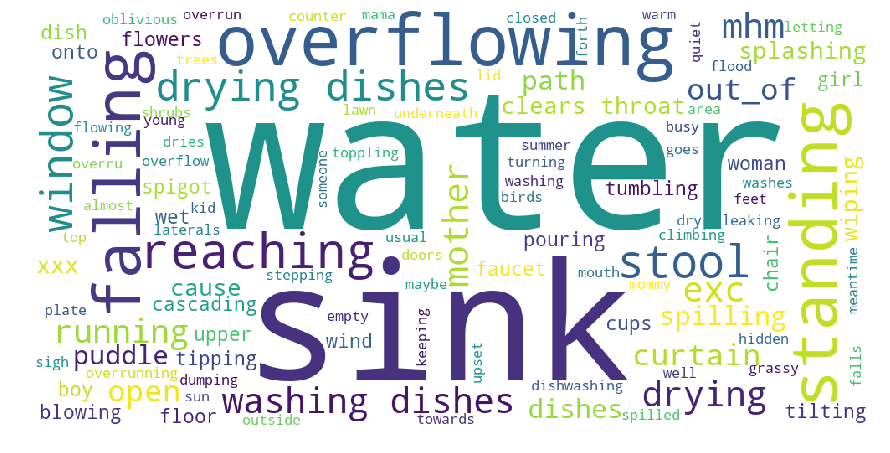

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 



#convert list to string and generate
unique_string=(" ").join(AD_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/AD_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

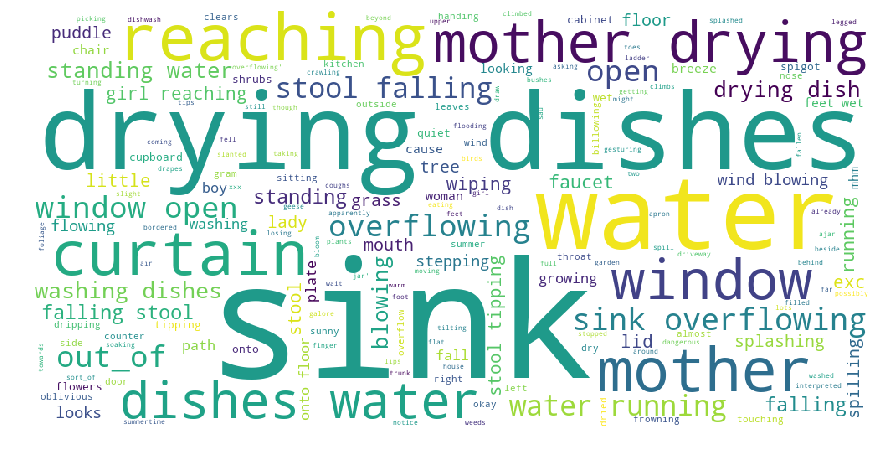

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

#convert list to string and generate
unique_string=(" ").join(H_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/H_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

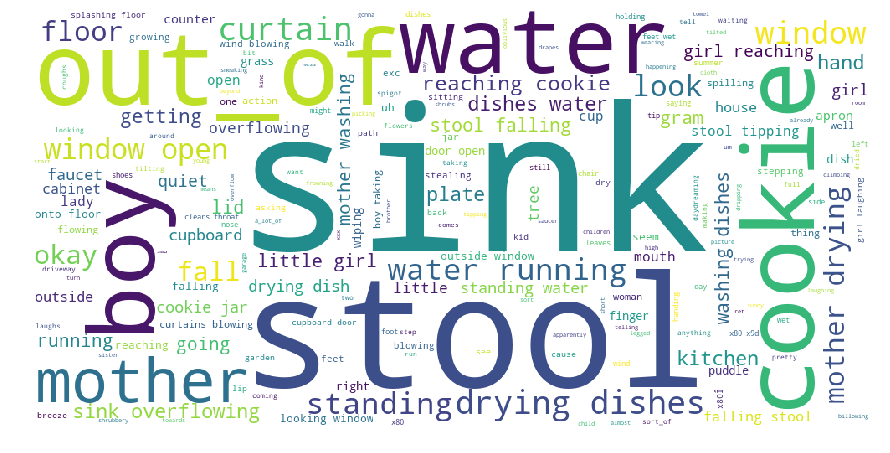

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

#convert list to string and generate
unique_string=(" ").join(H_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/H_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 



#convert list to string and generate
unique_string=(" ").join(AD_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/AD2_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 



#convert list to string and generate
unique_string=(" ").join(AD_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/AD2_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 



#convert list to string and generate
unique_string=(" ").join(AD_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/AD2_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 



#convert list to string and generate
unique_string=(" ").join(AD_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/AD2_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 



#convert list to string and generate
unique_string=(" ").join(AD_word_list)
wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("/content/AD2_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
#doc_att_to_df(reviews, doc_att) function works well here
doc_att=model.show_doc_attention(X)
#f=model.doc_att_to_df(reviews, doc_att)
 
  
  
docs_atts = []
for review, atts in zip(reviews, doc_att):
    doc_list = []
    for doc, att in zip(review, atts):
        doc_list.append({doc: att})
    docs_atts.append(doc_list)
    
b=pd.DataFrame([(x, y) for x, y in zip(docs_atts,reviews)],
                            columns=["doc_att", "transcript"])

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
b["doc_att"][0][4]

{nan: 0.14067493}

In [ ]:
X[0,4]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
f=model.doc_att_to_df(reviews, doc_att)

TypeError: ignored

In [ ]:
h=zip(reviews, doc_att)

In [ ]:
for x, y in zip(reviews, doc_att):
  print(y)

In [ ]:
ppp=[]
sent_att=han_model.show_sent_attention(X)
ff=han_model.sent_att_to_df(sent_tokenized_reviews, sent_att)
for i in range(len(ff)):  
  m=ff['sent_att'][i]
  s=len(m)
  best_sent=[]
  for j in range(s):
    dict_sent=m[j]
    dict1_sent_cond = {k:v for (k,v) in dict_sent.items() if v>0.05}
    best_sent.append(dict1_sent_cond)
  ppp.append(best_sent)

In [ ]:
import csv
with open('/content/sentences.csv', 'w', encoding='utf8', newline='') as output_file:
  writer = csv.writer(output_file)
  for i in range(len(ppp)):
      for d in ppp[i]:
        writer.writerows(d.items())

In [ ]:
ff['sent_att'][0]

[{'mhm .': 0.07009367},
 {'theres a young boy &uh going in a cookie jar .': 0.06934017},
 {'and theres a [/] &lit a girl [//] young girl .': 0.068205275},
 {'and im sayin(g) hes a boy (be)cause  [//] &hard its hardly [//] hard to tell anymore .': 0.066409886},
 {'&uh and hes [/] hes in the &c &t cookie jar .': 0.06655046},
 {'and theres a &s stool that he is on and it already is starting to fall over .': 0.06707223},
 {'and so is the water in the sink &uh is &ev overflowing in the sink .': 0.06499306},
 {'[+ gram]       \t\t&hm i [/] i dont know about the [//] this hickey here i [//] whether thats more than what i said .': 0.06253441},
 {'[+ es]       \t\t&uh like  [//] &uh the [/] the mother is near the girl .': 0.06341243},
 {'and shes [//] &uh &w &uh &h she has [/] &uh has +/.': 0.06158267},
 {'oh &uh i [/] i cant think of the +...       \t\tshe has &uh the shes tryin(g) to wipe [/] &uh wipe dishes .': 0.063897125},
 {'oh &a and stop the water from going out .': 0.069147855}]

In [ ]:
def best(s):
  best=[]
  for i in range(s):
    dict=fff['word_att'][i]
    dict1_cond = {k:v for (k,v) in dict.items() if v>0.05}
    best.append(dict1_cond)
  return(best)
  

In [ ]:
pp=[]
for i in range(len(X)):
  word_att=han_model.show_word_attention(X[i])
  sent_tokenized_review=sent_tokenize(reviews[i])
  fff=han_model.word_att_to_df(sent_tokenized_review, word_att)
  s=len(fff['word_att'])
  best=[]
  for j in range(s):
    dict=fff['word_att'][j]
    dict1_cond = {k:v for (k,v) in dict.items() if v>0.1}
    best.append(dict1_cond)  
  pp.append(best)
  

In [ ]:
import csv
with open('/content/words_34_loss.csv', 'w', encoding='utf8', newline='') as output_file2:
  writer = csv.writer(output_file2)
  for i in range(len(pp)):
      for d in pp[i]:
        writer.writerows(d.items())

In [ ]:
ropp=[]
for i in range(len(X)):
  word_att=han_model.show_word_attention(X[i])
  sent_tokenized_review=sent_tokenize(reviews[i])
  fff=han_model.word_att_to_df(sent_tokenized_review, word_att)
  s=len(fff['word_att'])
  p=best(s)  
  pp.append(p)

0     {'[//]': 0.009576102, 'the': 0.012396692, '[/]...
1     {'and': 0.013599173, '[//]': 0.006044331, 'the...
2     {'and': 0.014781531, '&um': 0.010422792, 'the'...
3     {'and': 0.012727314, 'the': 0.019267486, 'girl...
4     {'+': 0.010792856, 'be': 0.015355665, 'quiet':...
5     {'and': 0.009878057, 'shes': 0.014713961, 'put...
6     {'and': 0.01232259, '&um': 0.016946793, '(.)':...
7     {'the': 0.012095548, 'window': 0.011825117, 'i...
8     {'&hm': 0.008840613, '[x': 0.009673381, ']': 0...
9                                  {'(.)': 0.010205833}
10    {'shes': 0.016656881, 'doesnt': 0.02068565, '&...
11    {'oh': 0.012966979, 'whats': 0.008705806, '[/]...
12    {'[+': 0.009339924, 'exc]': 0.009637584, 'you'...
13    {'[+': 0.010792555, 'exc]': 0.014020711, '&=in...
14    {'and': 0.013823127, '&uh': 0.018706853, '(..)...
Name: word_att, dtype: object

In [ ]:
s=len(fff['word_att'])

In [ ]:
fff['word_att']

0     {'the': 0.0014939226, 'little': 0.0018655589, ...
1     {'+': 0.0018560443, 'dont': 0.001523802, 'tell...
2     {'shes': 0.0015977765, 'reaching': 0.001540410...
3     {'the': 0.0040582404, 'boys': 0.0011084798, 'g...
4     {'the': 0.007874616, 'lid': 0.001550833, 'fell...
5     {'the': 0.0010331507, 'stools': 0.0010965014, ...
6        {'its': 0.0015171305, 'slanted': 0.0060882745}
7     {'the': 0.0010271764, 'ladys': 0.0011405487, '...
8     {'waters': 0.00095810986, 'running': 0.0009816...
9     {'faucets': 0.0033912226, 'are': 0.0019351074,...
10    {'&um': 0.0010503697, 'dishes': 0.0012058289, ...
11    {'the': 0.0012898118, 'windows': 0.008619143, ...
12    {'waters': 0.0012797619, 'goin(g)': 0.00216195...
13    {'the': 0.0010397776, 'lady': 0.0009727547, 'h...
14    {'looks': 0.0010389292, 'like': 0.0010088837, ...
Name: word_att, dtype: object

In [ ]:
best(s)

[{},
 {'is': 0.2390077},
 {},
 {},
 {},
 {},
 {'[/]': 0.17062724, 'exc]': 0.1885049, 'im': 0.16309081},
 {},
 {},
 {},
 {},
 {'exc]': 0.17771411}]

In [ ]:
v=fff['word_att'][2].values()

In [ ]:
dict=fff['word_att'][2]

In [ ]:
dict[list(dict)[1]]

0.0013756149

Pooyan's Work

In [ ]:
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np


class MyBatchGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=1, shuffle=True):
        'Initialization'
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        return self.__data_generation(index)

    def on_epoch_end(self):
        'Shuffles indexes after each epoch'
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        Xb = np.empty((self.batch_size, *X[index].shape))
        yb = np.empty((self.batch_size, *y[index].shape))
        # naively use the same sample over and over again
        for s in range(0, self.batch_size):
            Xb[s] = X[index]
            yb[s] = y[index]
        return Xb, yb


# Parameters
N = 1000
halfN = int(N/2)
dimension = 2
lstm_units = 3

# Data
np.random.seed(123)  # to generate the same numbers
# create sequence lengths between 1 to 10
seq_lens = np.random.randint(1, 10, halfN)
X_zero = np.array([np.random.normal(0, 1, size=(seq_len, dimension)) for seq_len in seq_lens])
y_zero = np.zeros((halfN, 1))
X_one = np.array([np.random.normal(1, 1, size=(seq_len, dimension)) for seq_len in seq_lens])
y_one = np.ones((halfN, 1))
p = np.random.permutation(N)  # to shuffle zero and one classes
X = np.concatenate((X_zero, X_one))[p]
y = np.concatenate((y_zero, y_one))[p]

# Batch = 1
model = Sequential()
model.add(LSTM(lstm_units, input_shape=(None, dimension)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())
model.fit_generator(MyBatchGenerator(X, y, batch_size=1), epochs=2)

# Padding and Masking
special_value = -10.0
max_seq_len = max(seq_lens)
Xpad = np.full((N, max_seq_len, dimension), fill_value=special_value)
for s, x in enumerate(X):
    seq_len = x.shape[0]
    Xpad[s, 0:seq_len, :] = x
model2 = Sequential()
model2.add(Masking(mask_value=special_value, input_shape=(max_seq_len, dimension)))
model2.add(LSTM(lstm_units))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model2.summary())
model2.fit(Xpad, y, epochs=50, batch_size=32)

In [ ]:
Xpad

In [ ]:
X.shape

(1000,)

In [ ]:
X[999]

array([[ 0.15211279,  0.97930251],
       [ 2.68267849, -0.43800584],
       [ 0.99125466,  1.277006  ],
       [-0.97839058,  2.64066103],
       [ 0.72703579,  2.72098833],
       [-0.43870651,  0.18449066],
       [ 1.24366478,  0.71601204],
       [ 1.39604073,  1.82440503]])

In [ ]:
import pandas as pd
#doc=pd.read_csv("/content/NEW_doc_attention_bach_10_epoch_20.csv")
#sent=pd.read_csv("/content/NEW_sentence_attention_batch_10_epoch_20.csv")
doc=pd.read_csv("/content/selfattention_bach_10_epoch_30.csv")
sent=pd.read_csv("/content/Sentences_selfattention_batch_10_epoch_30.csv")

In [ ]:
doc_1= doc.drop(doc.columns[[0]], axis=1)

In [ ]:
sent_1=sent.drop(sent.columns[[0]], axis=1)

In [ ]:
id=doc_1.idxmax(axis = 1, skipna = True) 

In [ ]:
score=doc_1.max(axis = 1, skipna = True)

In [ ]:
score

In [ ]:
import ast
L=[]
for i in range(len(id)):
   k=ast.literal_eval(sent_1.iloc[0][int(id[i])])
  
                       

In [ ]:
dicts = {}
keys = range(4)
values = ["Hi", "I", "am", "John"]
for i in keys:
        dicts[i] = values[i]

In [ ]:
import ast
L=[]
V=[]
dict_new={}
for i in range(99,198):
  if not pd.isnull(sent_1.iloc[i][int(id[i])]):
    k=ast.literal_eval(sent_1.iloc[i][int(id[i])])
    for dd in k:
      for key, value in dd.items():
        if value==max([max(d.values()) for d in k]):
          #print(key)
          dict_new[key]=[value,score[i]]
          L.append(key)
          V.append(value)
    

In [ ]:
import heapq
from operator import itemgetter
top_sentences = heapq.nlargest(50, dict_new.items(), key=itemgetter(1))

In [ ]:
top_sentences

In [ ]:
r=pd.DataFrame(top_sentences)
r.to_csv('/content/top-50-sent_H.csv')

In [ ]:
ll=pd.DataFrame(L)
ll.to_csv('/content/New.csv')

In [ ]:
ast.literal_eval(sent_1.iloc[1][int(id[1])])

[{'["here\'s a cookie jar .': 0.047855776},
 {'", \'and the lid is off the cookie jar .': 0.058725305},
 {"', 'the boy is about to come down on the floor .": 0.15704773},
 {'\', \'and the girl +...\', "I don\'t know that much about girls .': 0.05057688},
 {'", \'but anyway &uh the housewife is in the kitchen .': 0.04559091},
 {"', 'and the [/] (.)": 0.057068847},
 {'the sink is overflowing .': 0.10628169},
 {"', 'and (..) the girl may be saying say \x92¢\\x80\\x9chahaha, I told you so\x92¢\\x80\\x9d or something like that .": 0.035675008},
 {"', 'and &uh I guess this must be the wife although it might not be because maybe that was an apron and &um maybe this was the &um +...', '<there is> [//] (.)": 0.02043632},
 {'this [/] this should be a window .': 0.029528748},
 {"', 'there .": 0.028783243},
 {"[+ exc]', 'the upper one is there .": 0.042531315},
 {"', '&uh it &um has a pathway .": 0.02829235},
 {'\', "&uh we don\'t know where the pathway is going to because we can\'t see it down be

In [ ]:
int(max([max(d.values()) for d in k]))

0

In [ ]:
for i in range(len(L)):
  for d in k:
    for key, value in d.items():
      if value==int(L[i]):
        print(key)

In [ ]:
sent_1.iloc[0][int(id[i])]

nan

In [ ]:
import numpy as np
sent_1.iloc[0][int(id[0])]


'[{"[\'mhm .": 0.026100932}, {"[+ exc]\', \'+< alright .": 0.021291649}, {\'[+ exc] \\\', "there\\\'s &um a young boy that\\\'s getting a cookie jar .\': 0.018816004}, {\'", "and it [//] he\\\'s &uh in bad shape because &uh the thing is fallin(g) over .\': 0.01568947}, {\'", "and in the picture the mother is washin(g) dishes and doesn\\\'t see it .\': 0.021563172}, {\'", \\\'and so <is the> [//] the water is overflowing in the sink .\': 0.14822887}, {\'\\\', "and the dishes might <get falled [* +ed] over if you don\\\'t> [//] fell [//] fall over there [/] there if you don\\\'t get it .\': 0.037967518}, {\'", "and it [//] there [//] it\\\'s a picture of a kitchen window .\': 0.11562494}, {\'", \\\'and the curtains are very &uh distinct .\': 0.050454184}, {"\', \'but the water is &flow still flowing .\']": 0.1806674}]'

In [ ]:
kk=max([max(d.values()) for d in k])

In [ ]:
id[0]

'0'

In [ ]:
kk

0.1806674

In [ ]:
import ast
k=ast.literal_eval(sent_1.iloc[0][int(id[0])])

In [ ]:
k[0].values()

dict_values([0.026100932])

In [ ]:
sent.iloc[0][0]

'sent_att'

In [ ]:
max(part.values() for part in k)

TypeError: ignored

In [ ]:
k[2].values()

dict_values([0.018816004])

In [ ]:
kk=max([max(d.values()) for d in k])

In [ ]:
[d.values() for d in k]

[dict_values([0.026100932]),
 dict_values([0.021291649]),
 dict_values([0.018816004]),
 dict_values([0.01568947]),
 dict_values([0.021563172]),
 dict_values([0.14822887]),
 dict_values([0.037967518]),
 dict_values([0.11562494]),
 dict_values([0.050454184]),
 dict_values([0.1806674])]

In [ ]:
k[4]

{'", "and in the picture the mother is washin(g) dishes and doesn\'t see it .': 0.021563172}

In [ ]:
L[0]

0.1806674

In [ ]:
sent = '''the USS Ronald Reagan - an aircraft carrier docked in Japan - during his tour of the region, vowing to "defeat any attack and meet any use of conventional or nuclear weapons with an overwhelming and effective American response".
North Korea and the US have ratcheted up tensions in recent weeks and the movement of the strike group had raised the question of a pre-emptive strike by the US.
On Wednesday, Mr Pence described the country as the "most dangerous and urgent threat to peace and security" in the Asia-Pacific.'''

In [ ]:
cd /content/Text-Attention-Heatmap-Visualization

/content/Text-Attention-Heatmap-Visualization


In [ ]:
words = sent.split()
word_num = len(words)
attention = [(x+1.)/word_num*100 for x in range(word_num)]
import random
random.seed(42)
random.shuffle(attention)
color = 'red'


In [ ]:
from text_attention import generate
generate(words, attention, "sample.tex", color)

In [ ]:
#Data Augmentation
!git clone https://github.com/jasonwei20/eda_nlp.git

Cloning into 'eda_nlp'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 379 (delta 18), reused 1 (delta 0), pack-reused 349
Receiving objects: 100% (379/379), 20.41 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import pandas as pd
dataframe = pd.read_csv("/content/Revised_Dementia.csv",delimiter="\t", encoding='latin-1')
df=dataframe.fillna('ENGINE')
#dataframe.to_csv("New_Control_2.csv", encoding='latin-1', index=False)

In [ ]:
Review1_Dementia=pd.concat([df['sentiment'], df['review1']], axis=1)
Review2_Dementia=pd.concat([df['sentiment'], df['review2']], axis=1)
Review3_Dementia=pd.concat([df['sentiment'], df['review3']], axis=1)
Review4_Dementia=pd.concat([df['sentiment'], df['review4']], axis=1)
Review5_Dementia=pd.concat([df['sentiment'], df['review5']], axis=1)

In [ ]:
Review1_Dementia.to_csv('/content/review1_Dementia.txt',sep='\t', encoding='latin1',index=False,header=False)
Review2_Dementia.to_csv('/content/review2_Dementia.txt', sep='\t',encoding='latin1',index=False,header=False)
Review3_Dementia.to_csv('/content/review3_Dementia.txt', sep='\t',encoding='latin1',index=False,header=False)
Review4_Dementia.to_csv('/content/review4_Dementia.txt', sep='\t',encoding='latin1',index=False,header=False)
Review5_Dementia.to_csv('/content/review5_Dementia.txt', sep='\t',encoding='latin1',index=False,header=False)

In [ ]:
!python /content/eda_nlp/code/augment.py --input=/content/review1_Dementia.txt --output=/content/review1_Dementia_augmented.txt --num_aug=1 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review2_Dementia.txt --output=/content/review2_Dementia_augmented.txt --num_aug=1 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review3_Dementia.txt --output=/content/review3_Dementia_augmented.txt --num_aug=1 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review4_Dementia.txt --output=/content/review4_Dementia_augmented.txt --num_aug=1 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review5_Dementia.txt --output=/content/review5_Dementia_augmented.txt --num_aug=1 --alpha=0.1

In [ ]:
import pandas as pd
dataframe = pd.read_csv("/content/Revised_Control.csv",delimiter=",", encoding='latin-1')
df=dataframe.fillna('ENGINE')
#dataframe.to_csv("New_Control_2.csv", encoding='latin-1', index=False)

In [ ]:
dataframe

In [ ]:
Review1_Control=pd.concat([df['sentiment'], df['review1']], axis=1)
Review2_Control=pd.concat([df['sentiment'], df['review2']], axis=1)
Review3_Control=pd.concat([df['sentiment'], df['review3']], axis=1)
Review4_Control=pd.concat([df['sentiment'], df['review4']], axis=1)
Review5_Control=pd.concat([df['sentiment'], df['review5']], axis=1)

In [ ]:
Review1_Control.to_csv('/content/review1_Control.txt',sep='\t', encoding='latin1',index=False,header=False)
Review2_Control.to_csv('/content/review2_Control.txt', sep='\t',encoding='latin1',index=False,header=False)
Review3_Control.to_csv('/content/review3_Control.txt', sep='\t',encoding='latin1',index=False,header=False)
Review4_Control.to_csv('/content/review4_Control.txt', sep='\t',encoding='latin1',index=False,header=False)
Review5_Control.to_csv('/content/review5_Control.txt', sep='\t',encoding='latin1',index=False,header=False)

In [ ]:
Review1_Control

In [ ]:
!python /content/eda_nlp/code/augment.py --input=/content/review1_Control.txt --output=/content/review1_Control_augmented.txt --num_aug=3 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review2_Control.txt --output=/content/review2_Control_augmented.txt --num_aug=3 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review3_Control.txt --output=/content/review3_Control_augmented.txt --num_aug=3 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review4_Control.txt --output=/content/review4_Control_augmented.txt --num_aug=3 --alpha=0.1
!python /content/eda_nlp/code/augment.py --input=/content/review5_Control.txt --output=/content/review5_Control_augmented.txt --num_aug=3 --alpha=0.1

generated augmented sentences with eda for /content/review1_Control.txt to /content/review1_Control_augmented.txt with num_aug=3
generated augmented sentences with eda for /content/review2_Control.txt to /content/review2_Control_augmented.txt with num_aug=3
generated augmented sentences with eda for /content/review3_Control.txt to /content/review3_Control_augmented.txt with num_aug=3
generated augmented sentences with eda for /content/review4_Control.txt to /content/review4_Control_augmented.txt with num_aug=3
generated augmented sentences with eda for /content/review5_Control.txt to /content/review5_Control_augmented.txt with num_aug=3


In [ ]:
review1_Control_augmented=pd.read_csv('/content/review1_Control_augmented.txt', delimiter='\t',usecols=[1])
review2_Control_augmented=pd.read_csv('/content/review2_Control_augmented.txt', delimiter='\t',usecols=[1])
review3_Control_augmented=pd.read_csv('/content/review3_Control_augmented.txt', delimiter='\t',usecols=[1])
review4_Control_augmented=pd.read_csv('/content/review4_Control_augmented.txt', delimiter='\t',usecols=[1])
review5_Control_augmented=pd.read_csv('/content/review5_Control_augmented.txt', delimiter='\t',usecols=[1])

In [ ]:
review1_Dementia_augmented=pd.read_csv('/content/review1_Dementia_augmented.txt', delimiter='\t',usecols=[1])
review2_Dementia_augmented=pd.read_csv('/content/review2_Dementia_augmented.txt', delimiter='\t',usecols=[1])
review3_Dementia_augmented=pd.read_csv('/content/review3_Dementia_augmented.txt', delimiter='\t',usecols=[1])
review4_Dementia_augmented=pd.read_csv('/content/review4_Dementia_augmented.txt', delimiter='\t',usecols=[1])
review5_Dementia_augmented=pd.read_csv('/content/review5_Dementia_augmented.txt', delimiter='\t',usecols=[1])

In [ ]:
Control_augmented=
Dementia_augmented=

In [ ]:
import numpy as np
Control_augmented=pd.concat([review1_Control_augmented, review2_Control_augmented, review3_Control_augmented,review4_Control_augmented, review5_Control_augmented], axis= 1)
#Dementia_augmented=pd.concat([review1_Dementia_augmented, review2_Dementia_augmented, review3_Dementia_augmented,review4_Dementia_augmented, review5_Dementia_augmented], axis= 1)

In [ ]:
Control_augmented.to_csv('/content/Control_augmented.csv')
#Dementia_augmented.to_csv('/content/Dementia_augmented.csv')

In [ ]:
len(Dementia_augmented)

387

In [ ]:
Total_augmented=pd.concat(Dementia_augmented, Control_augmented)

In [ ]:
DF=dataframe.replace('OK', None)
DF.to_csv('/content/review4_augmented.csv')

In [ ]:
df=pd.read_csv('/content/Total_augmented_3_layers.csv', encoding='latin-1')

In [ ]:
df = df.replace(r'engine', np.nan, regex=True)
df = df.replace(r'locomotive', np.nan, regex=True)
df = df.replace(r'railway', np.nan, regex=True)

In [ ]:
df.to_csv('/content/Final_Total_augmented_3_layers.csv')